# Computer Vision with HuggingFace

## Setup

In [1]:
import torch
import numpy as np
from datasets import load_dataset
import evaluate

from transformers import (
    ViTFeatureExtractor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer,
)

/Users/mmenendezg/Developer/Platzi/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparing the dataset

In [2]:
ds = load_dataset("beans")

Found cached dataset beans (/Users/mmenendezg/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)
100%|██████████| 3/3 [00:00<00:00, 837.08it/s]


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

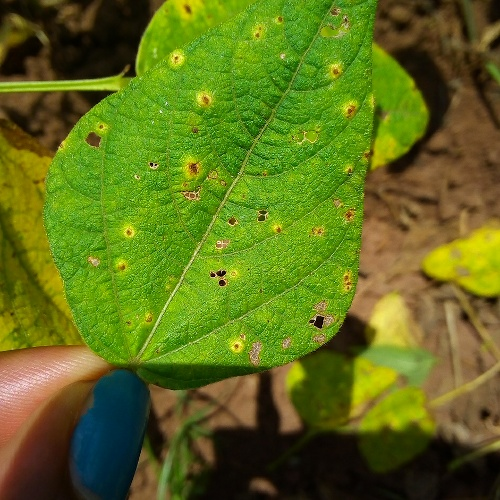

In [4]:
ex = ds["train"][500]
image_ex = ex["image"]
image_ex

In [5]:
labels = ds["train"].features["labels"]
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [6]:
labels.int2str(ex["labels"])

'bean_rust'

## Loading the ViT Feature Extractor

In [7]:
repo_id = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(repo_id)

/Users/mmenendezg/Developer/Platzi/.venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [8]:
print(feature_extractor)

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [9]:
pt_tensor = feature_extractor(image_ex, return_tensors="pt")

## Processing the dataset

In [10]:
def process_example(example):
    inputs = feature_extractor(example["image"], return_tensors="pt")
    inputs["labels"] = example["labels"]
    return inputs

In [11]:
process_example(ds["train"][25])

{'pixel_values': tensor([[[[ 0.2627,  0.2549,  0.2471,  ...,  0.2941,  0.3020,  0.2078],
          [ 0.2471,  0.2471,  0.2314,  ..., -0.1451, -0.0824,  0.0745],
          [ 0.2471,  0.2706,  0.2549,  ..., -0.3490, -0.1216,  0.1765],
          ...,
          [-0.7804, -0.7490, -0.7176,  ...,  0.2706,  0.3255,  0.3176],
          [-0.7569, -0.6941, -0.7255,  ...,  0.2078,  0.2314,  0.2549],
          [-0.6941, -0.7412, -0.7961,  ...,  0.2000,  0.2078,  0.2471]],

         [[-0.0118, -0.0118, -0.0196,  ...,  0.1686,  0.1529,  0.0353],
          [-0.0275, -0.0275, -0.0353,  ..., -0.2863, -0.2392, -0.0980],
          [-0.0431, -0.0118, -0.0118,  ..., -0.5137, -0.2941, -0.0039],
          ...,
          [-0.8431, -0.8431, -0.6941,  ...,  0.7098,  0.7333,  0.7490],
          [-0.8353, -0.7804, -0.7490,  ...,  0.6627,  0.6706,  0.7020],
          [-0.7725, -0.8118, -0.8353,  ...,  0.6549,  0.6706,  0.7176]],

         [[-0.2627, -0.2627, -0.2549,  ..., -0.1373, -0.1529, -0.2706],
          [-0

In [12]:
def process_examples(example_batch):
    inputs = feature_extractor([x for x in example_batch["image"]], return_tensors="pt")
    inputs["labels"] = example_batch["labels"]
    return inputs

In [13]:
prepared_ds = ds.with_transform(process_examples)

In [14]:
prepared_ds["train"][0]

{'pixel_values': tensor([[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],
 
         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],
 
         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-

## Data Collator

In [15]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch]),
    }

## Training and evaluation

### Define the metric

In [16]:
metric = evaluate.load("accuracy")

In [17]:
def compute_metrics(prediction):
    return metric.compute(
        predictions=np.argmax(prediction.predictions, axis=1),
        references=prediction.labels_ids,
    )

### Configure the trainer

In [18]:
labels = ds["train"].features["labels"].names

model = ViTForImageClassification.from_pretrained(
    repo_id,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: i for i, c in enumerate(labels)},
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
training_args = TrainingArguments(
    output_dir="./vit_model/",
    evaluation_strategy="steps",
    num_train_epochs=4,
    learning_rate=2e-4,
    remove_unused_columns=False,
    push_to_hub=True,
    load_best_model_at_end=True,
)

In [20]:
!huggingface-cli login

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to /Users/mmenendezg/.cache/huggingface/token
Login successful


In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

/Users/mmenendezg/Developer/Platzi/machine-learning/transfer_learning_huggingface/Notebooks/./vit_model/ is already a clone of https://huggingface.co/mmenendezg/vit_model. Make sure you pull the latest changes with `repo.git_pull()`.


In [22]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

/Users/mmenendezg/Developer/Platzi/.venv/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 96%|█████████▌| 500/520 [11:07<00:26,  1.34s/it]

{'loss': 0.136, 'learning_rate': 7.692307692307694e-06, 'epoch': 3.85}


AttributeError: 'EvalPrediction' object has no attribute 'labels_ids'

In [ ]:
metrics = trainer.evaluate(prepared_ds["test"])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)